<a href="https://colab.research.google.com/github/abrahamkoloboe27/MLOps_Test/blob/main/Fruit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruits Recognintion


## Installer les dépendances nécéssaires

In [ ]:
! pip install -U albumentations keras tensorflow opencv-python matplotlib netron

## Importer les données

In [2]:
! git clone https://github.com/fruits-360/fruits-360-100x100.git  /content/data

Cloning into '/content/data'...
remote: Enumerating objects: 94555, done.
remote: Counting objects: 100% (3809/3809), done.
remote: Compressing objects: 100% (3799/3799), done.
remote: Total 94555 (delta 32), reused 3787 (delta 10), pack-reused 90746 (from 1)
Receiving objects: 100% (94555/94555), 723.85 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (94112/94112), done.


In [3]:
import albumentations as A
import cv2
import os
import pandas as pd
import plotly.express as px
from PIL import Image
import random
import logging
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Importing required libraries.")
import keras
from keras import layers
from tensorflow import data as tf_data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import datetime
import shutil
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import numpy as np
import matplotlib.pyplot as plt
os.makedirs("models", exist_ok=True)
os.makedirs("artefacts", exist_ok=True)
os.environ['NO_ALBUMENTATIONS_UPDATE'] = '1'

In [4]:
image_size = ( 100 , 100 )
batch_size = 128
epochs = 3
patience = 2

In [5]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data/Training",
    validation_split=0.25,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 70491 files belonging to 141 classes.
Using 52869 files for training.
Using 17622 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)

image_counts = {}
for label in range(num_classes):
  image_counts[class_names[label]] = 0

for images, labels in train_ds:
  for label in labels.numpy():
    image_counts[class_names[label]] += 1

df_train = pd.DataFrame.from_dict(image_counts, orient='index', columns=["Nombre d'images"])
fig = px.bar(df_train, x=df_train.index, y='Nombre d\'images', title='Nombre d\'images par catégorie')
fig.show()

In [7]:
class_names = val_ds.class_names
num_classes = len(class_names)

image_counts = {}
for label in range(num_classes):
  image_counts[class_names[label]] = 0

for images, labels in val_ds:
  for label in labels.numpy():
    image_counts[class_names[label]] += 1

df_val = pd.DataFrame.from_dict(image_counts, orient='index', columns=["Nombre d'images"])
fig = px.bar(df_val, x=df_val.index, y='Nombre d\'images', title='Nombre d\'images par catégorie')
fig.show()

In [8]:
df_train["Pourcentage"] = df_train["Nombre d'images"] / df_train["Nombre d'images"].sum()
df_train["Train/Val"] = "Train"
df_val["Pourcentage"] = df_val["Nombre d'images"] / df_val["Nombre d'images"].sum()
df_val["Train/Val"] = "Val"
df = pd.concat([df_train, df_val])
fig = px.bar(df, x=df.index, y='Pourcentage',
             color='Train/Val',
             barmode='group',
             title='Pourcentage d\'images par catégorie')
fig.show()

Displaying images for data/Training/Pomelo Sweetie 1


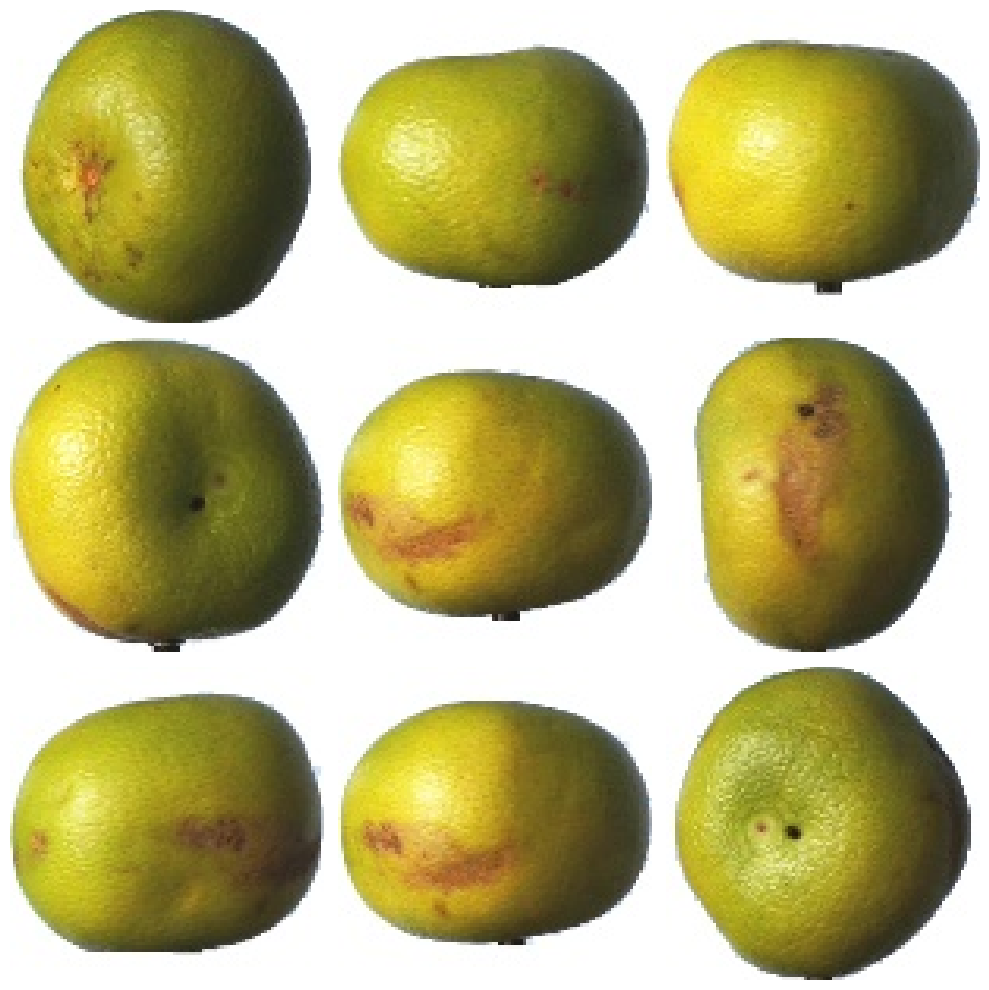

In [9]:


def display_images_grid(directory, num_rows=3, num_cols=3):
  """Displays a grid of images from a specified directory.

  Args:
    directory: The path to the directory containing the images.
    num_rows: The number of rows in the grid.
    num_cols: The number of columns in the grid.
  """
  image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
  num_images = min(len(image_files), num_rows * num_cols)

  if not image_files:
    print(f"No images found in {directory}")
    return

  fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
  axs = axs.flatten()

  for i in range(num_images):
    image_path = os.path.join(directory, random.choice(image_files))  # Choose a random image
    try:
      img = Image.open(image_path)
      axs[i].imshow(np.asarray(img))
      axs[i].axis('off')
    except Exception as e:
      print(f"Error loading image {image_path}: {e}")

  for i in range(num_images, num_rows * num_cols):
    axs[i].axis('off')

  plt.tight_layout()
  plt.show()


# Example Usage:
# Assuming you have a directory named 'data/Training/Apple Braeburn'
# You can modify the directory path according to your dataset structure.
subdirectories = [
    os.path.join("data/Training", folder)
    for folder in os.listdir("data/Training")
    if os.path.isdir(os.path.join("data/Training", folder))
]
random.shuffle(subdirectories)  # Shuffle the list of subdirectories
for directory in subdirectories[:1]: # Display a grid for a random selection of 5 subdirectories
  print(f"Displaying images for {directory}")
  display_images_grid(directory)


## Data Augmentation

In [10]:
import albumentations as A
import cv2
import os
import shutil
import os

# Define the augmentation pipeline
transforms = [
    A.RandomRotate90( p=1.0),
    A.Transpose( p=1.0),
    A.VerticalFlip( p=1.0),
    A.HorizontalFlip( p=1.0),
    A.RandomBrightnessContrast( p=1.0),
    A.RandomBrightnessContrast(brightness_limit=0.75, contrast_limit=0.75, p=1.0),
    #A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
]

# Define the path to your data directory
data_dir = 'data/Training'

# Define the path to your augmented data directory
augmented_data_dir = 'data/train-augmented'
# Loop through each class directory
for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    augmented_class_path = os.path.join(augmented_data_dir, class_dir)

    # Create the augmented class directory if it doesn't exist
    if not os.path.exists(augmented_class_path):
        os.makedirs(augmented_class_path)

    # Loop through each image in the class directory
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        # Load the image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Copy the original image to the augmented data directory
        original_img_path = os.path.join(augmented_class_path, img_file)
        shutil.copy(img_path, original_img_path)

        # Apply each transformation in the pipeline to the image
        for i, transform in enumerate(transforms):
            augmented = transform(image=img)
            augmented_img = augmented['image']

            # Save the transformed image to the augmented data directory
            transformed_img_file = f'transformed_{i}_{img_file}'
            transformed_img_path = os.path.join(augmented_class_path, transformed_img_file)
            cv2.imwrite(transformed_img_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

Displaying augmented images for data/train-augmented/Walnut 1


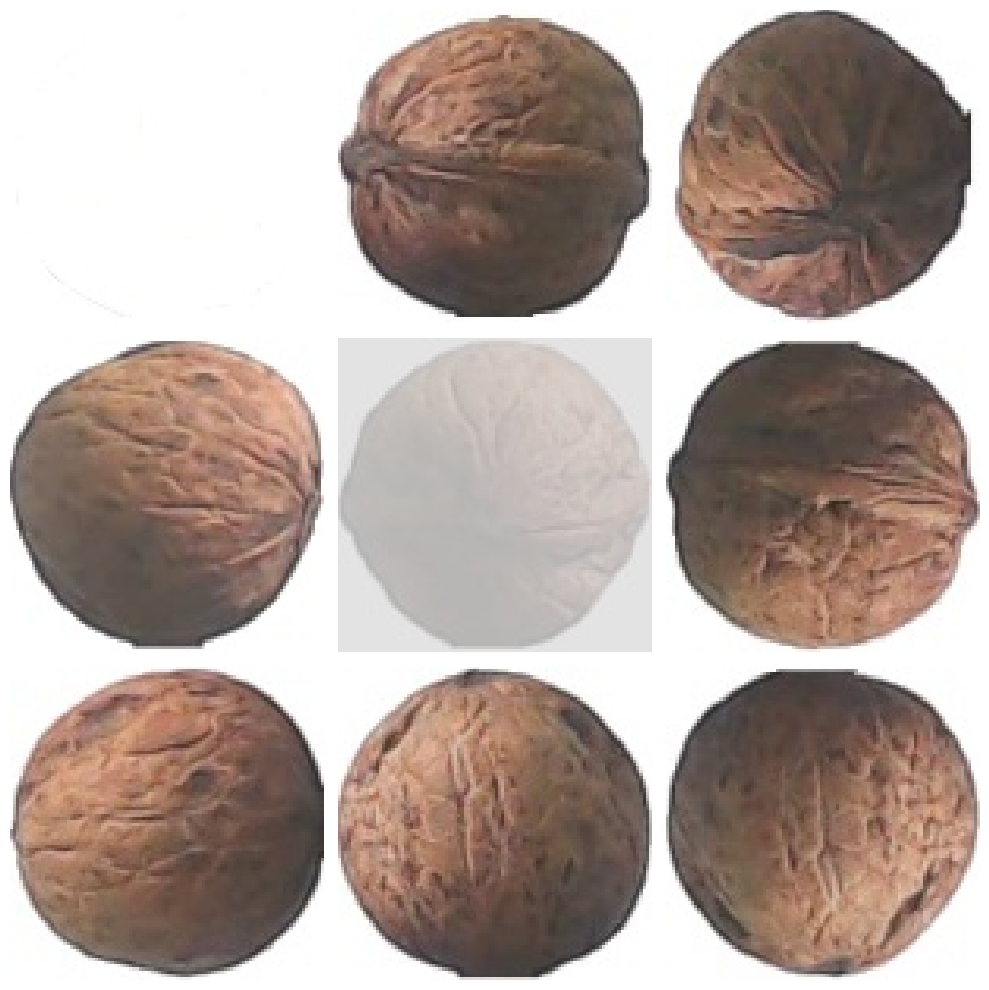

In [11]:
def display_images_grid_augmented(directory, num_rows=3, num_cols=3):
  """Displays a grid of images from a specified directory, filtering for augmented images.

  Args:
    directory: The path to the directory containing the images.
    num_rows: The number of rows in the grid.
    num_cols: The number of columns in the grid.
  """
  image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.startswith("transformed")]
  num_images = min(len(image_files), num_rows * num_cols)

  if not image_files:
    print(f"No transformed images found in {directory}")
    return

  fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
  axs = axs.flatten()

  for i in range(num_images):
    image_path = os.path.join(directory, random.choice(image_files))  # Choose a random image
    try:
      img = Image.open(image_path)
      axs[i].imshow(np.asarray(img))
      axs[i].axis('off')
    except Exception as e:
      print(f"Error loading image {image_path}: {e}")

  for i in range(num_images, num_rows * num_cols):
    axs[i].axis('off')

  plt.tight_layout()
  plt.show()

# Example Usage (using the augmented data directory)
subdirectories = [
    os.path.join("data/train-augmented", folder)
    for folder in os.listdir("data/train-augmented")
    if os.path.isdir(os.path.join("data/train-augmented", folder))
]
random.shuffle(subdirectories)  # Shuffle the list of subdirectories

for directory in subdirectories[:1]: # Display a grid for a random selection of 5 subdirectories
  print(f"Displaying augmented images for {directory}")
  display_images_grid_augmented(directory)

Displaying images for data/train-augmented/Avocado 1


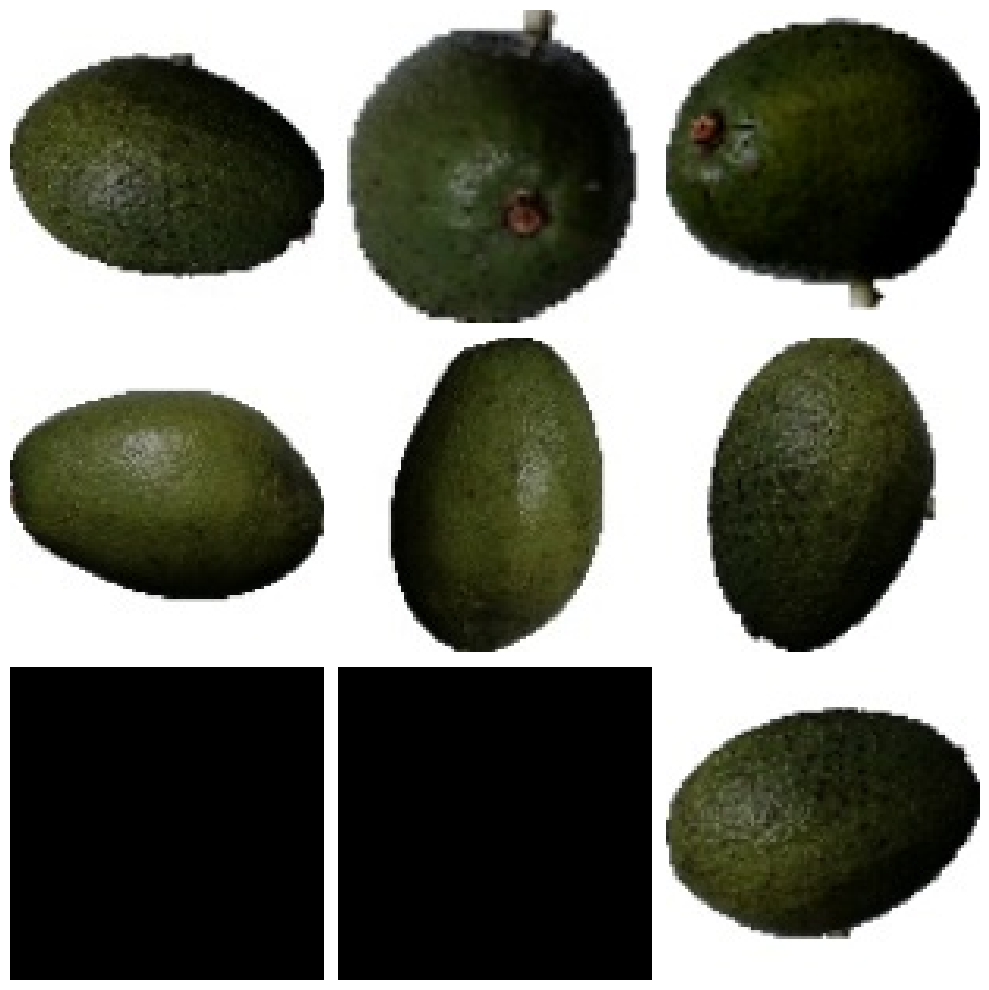

In [12]:
def display_images_grid(directory, num_rows=3, num_cols=3):
  """Displays a grid of images from a specified directory.

  Args:
    directory: The path to the directory containing the images.
    num_rows: The number of rows in the grid.
    num_cols: The number of columns in the grid.
  """
  image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
  num_images = min(len(image_files), num_rows * num_cols)

  if not image_files:
    print(f"No images found in {directory}")
    return

  fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
  axs = axs.flatten()

  for i in range(num_images):
    image_path = os.path.join(directory, random.choice(image_files))  # Choose a random image
    try:
      img = Image.open(image_path)
      axs[i].imshow(np.asarray(img))
      axs[i].axis('off')
    except Exception as e:
      print(f"Error loading image {image_path}: {e}")

  for i in range(num_images, num_rows * num_cols):
    axs[i].axis('off')

  plt.tight_layout()
  plt.show()


# Example Usage:
# Assuming you have a directory named ''data/train-augmented'/Apple Braeburn'
# You can modify the directory path according to your dataset structure.
subdirectories = [
    os.path.join("data/train-augmented", folder)
    for folder in os.listdir('data/train-augmented')
    if os.path.isdir(os.path.join('data/train-augmented', folder))
]
random.shuffle(subdirectories)  # Shuffle the list of subdirectories
for directory in subdirectories[:1]: # Display a grid for a random selection of 5 subdirectories
  print(f"Displaying images for {directory}")
  display_images_grid(directory)


In [13]:
original_image_count = 0
augmented_image_count = 0

for class_dir in os.listdir(data_dir):
  class_path = os.path.join(data_dir, class_dir)
  for img_file in os.listdir(class_path):
    original_image_count += 1


for class_dir in os.listdir(augmented_data_dir):
  class_path = os.path.join(augmented_data_dir, class_dir)
  for img_file in os.listdir(class_path):
    augmented_image_count += 1


print(f"Nombre d'images d'origine: {original_image_count}")
print(f"Nombre d'images après data augmentation: {augmented_image_count}")

Nombre d'images d'origine: 70491
Nombre d'images après data augmentation: 493437


In [14]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data/train-augmented",
    validation_split=0.25,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 493437 files belonging to 141 classes.
Using 370078 files for training.
Using 123359 files for validation.


In [15]:
# Define the models
def create_cnn_model(num_classes):
  model = keras.Sequential([
      layers.Input(shape=(100, 100, 3)),
      layers.Conv2D(32, (3, 3), activation='relu',
                    #input_shape=(100, 100, 3)
                    ),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(128, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])
  return model

def create_resnet_model(num_classes):

  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
  base_model.trainable = False

  model = keras.Sequential([
      base_model,
      layers.Dense(num_classes, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes, activation='relu'),
      layers.GlobalAveragePooling2D(),
      layers.Dense(num_classes, activation='softmax')
  ])
  return model

def create_efficientnet_model(num_classes):

  base_model = EfficientNetB0(weights='imagenet', include_top=False,
                              input_shape=(100, 100, 3))
  base_model.trainable = False

  model = keras.Sequential([

      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(num_classes*3, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Dense(num_classes*2, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Dense(num_classes, activation='softmax')
  ])
  return model

def create_vgg16_model(num_classes):

  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
  base_model.trainable = False

  model = keras.Sequential([
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dropout(0.3),

      # Ajout d'une couche Dense avec activation ReLU
      layers.Dense(512, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),

      # Ajout d'une autre couche dense pour mieux capturer les caractéristiques
      layers.Dense(256, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.4),

      # Couche de sortie avec activation softmax (classification multi-classe)
      layers.Dense(num_classes, activation='softmax')
  ])
  return model


# Compile the models
def compile_model(model):
  model.compile(
        optimizer=keras.optimizers.Adam(3e-4),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
  #model.save_weights("models/initial_weights.weights.h5")
  return model

callbacks = [
        keras.callbacks.ModelCheckpoint(
            f"models/best_model_cnn.keras", save_best_only=True, monitor="val_acc", mode="max"
        ),
        keras.callbacks.EarlyStopping(monitor='val_acc', patience=patience, mode="max",restore_best_weights=True),
        keras.callbacks.CSVLogger(f'artefacts/training_log_cnn.csv')  # Save training log
]


In [16]:
cnn = create_cnn_model(num_classes)
cnn = compile_model(cnn)
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 141)                 │          18,189 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,749,965 (6.68 MB)

 Trainable params: 1,749,965 (6.68 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
efficent_net = create_efficientnet_model(num_classes)
efficent_net = compile_model(efficent_net)
efficent_net.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 423)                 │         541,863 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 423)                 │           1,692 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 423)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 282)                 │         119,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 282)                 │           1,128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 282)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 141)                 │          39,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,753,725 (18.13 MB)

 Trainable params: 702,744 (2.68 MB)

 Non-trainable params: 4,050,981 (15.45 MB)

In [ ]:
history_cnn = cnn.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/5
2892/2892 ━━━━━━━━━━━━━━━━━━━━ 209s 70ms/step - acc: 0.4347 - loss: 3.1734 - val_acc: 0.9035 - val_loss: 0.4103
Epoch 2/5
2892/2892 ━━━━━━━━━━━━━━━━━━━━ 216s 56ms/step - acc: 0.9159 - loss: 0.3545 - val_acc: 0.9261 - val_loss: 0.3253
Epoch 3/5


In [ ]:
# Plot training & validation accuracy values
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
history_efficent_net = efficent_net.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks
)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_efficent_net.history['acc'])
plt.plot(history_efficent_net.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history_efficent_net.history['loss'])
plt.plot(history_efficent_net.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()